In [153]:
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import pandas as pd
import seaborn as sns

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM,Dropout, Conv1D, Lambda, GRU
from tensorflow.keras.losses import Huber
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

In [103]:
# window_size(전일 몇일치 데이터로 예측할 것인가)를 이용해서 LSTM에 필요한 데이터셋을 만들어주는 모듈
def making_batch(data_x, data_y, window_size):
  # 사용법 : X_data_batch, y_data_batch = making_batch(data_x, data_y, 50)
  # ndarray 만을 넣어야 함.
  new_data_x = []
  new_data_y = []
  for i in range(len(data_x) - window_size):
    _x = data_x[i: i+window_size]
    _y = data_y[i+window_size]
    new_data_x.append(_x)
    new_data_y.append(_y)
  new_data_x = np.array(new_data_x)
  new_data_y = np.array(new_data_y)
  return new_data_x, new_data_y

# 종가만으로 batch 만드는 프로그램.
def making_batch_pr(data_y, window_size):
  new_data_x = []
  new_data_y = []
  for i in range(len(data) - window_size):
    _x = data_y[i: i+window_size] # 종가 20일치
    _y = data_y[i+window_size] # 그다음 하루의 종가
    new_data_x.append(_x) # 20일치 x에 넣고
    new_data_y.append(_y) # 1일치 y에 넣는다.
  return new_data_x, new_data_y
# window_size 만큼의 x 데이터의 결과값이 y[window_size+1] 이 된다.
# 즉 그 전날 60일만큼의 데이터가 그 다음의 주가를 예측한다.


In [83]:
aa = []
y_data.index

Int64Index([20180515, 20180516, 20180517, 20180518, 20180521, 20180523,
            20180524, 20180525, 20180528, 20180529,
            ...
            20210308, 20210309, 20210310, 20210311, 20210312, 20210315,
            20210316, 20210317, 20210318, 20210319],
           dtype='int64', name='date', length=700)

In [41]:
# 데이터를 가져오는 함수# 데이터를 가져오는 모듈
def getting_data(need_date='all'):
  # need_date 로는 필요한 일수를 입력한다.
  samsung = pd.read_csv('./A005930.csv')
  cols = ['DAY','CUR_PR','HIGH_PR','LOW_PR','CLO_PR','FOR_STOR']
  samsung = samsung[cols]
  samsung = samsung.rename(columns = {'DAY':'date','CUR_PR':'open','HIGH_PR':'high','LOW_PR':'low','CLO_PR':'close','FOR_STOR':'volume'})
  samsung.sort_values(by='date', inplace=True)
  samsung.reset_index(drop=True, inplace=True)
  if need_date=='all':
    return samsung
  else:
    samsung = samsung[-need_date:]
    samsung.reset_index(drop=True, inplace=True)
    return samsung
  

In [160]:
# 모델 구조 만들고 컴파일해주는 모듈
def create_model_LSTM(input_shape, dropout_rate,
                 num_first_LSTM_nodes, num_second_LSTM_nodes, 
                 activation='relu',learning_rate=0.00001):
  model = Sequential()
  model.add(LSTM(units = num_first_LSTM_nodes, activation=activation, return_sequences = True, input_shape=input_shape))
  # LSTM 1층
  #model.add(Dropout(dropout_rate))
  # 드롭아웃 층
  model.add(LSTM(units = num_second_LSTM_nodes, activation=activation))
  # LSTM 2층
  #model.add(Dropout(dropout_rate))
  model.add(Dense(units = 1)) # 출력증

  adam = Adam(lr=learning_rate)
  loss=Huber()
  model.compile(optimizer=adam, loss=loss)
  return model

In [161]:
# 모델 구조 만들고 컴파일해주는 모듈
def create_model_GRU(input_shape, dropout_rate,
                 num_first_LSTM_nodes, num_second_LSTM_nodes, 
                 activation='relu',learning_rate=0.00001):
  model = Sequential()
  model.add(GRU(units = num_first_LSTM_nodes, activation=activation, return_sequences = True, input_shape=input_shape))
  # LSTM 1층
  #model.add(Dropout(dropout_rate))
  # 드롭아웃 층
  model.add(GRU(units = num_second_LSTM_nodes, activation=activation))
  # LSTM 2층
  #model.add(Dropout(dropout_rate))
  model.add(Dense(units = 1)) # 출력증

  adam = Adam(lr=learning_rate)
  loss=Huber()
  model.compile(optimizer=adam, loss=loss)
  return model

In [49]:
samsung = getting_data(700)
samsung

,date,open,high,low,close,volume
0,20180515,50200,50400,49100,49200,3383954
1,20180516,49200,50200,49150,49850,3385282
2,20180517,50300,50500,49400,49400,3383087
3,20180518,49900,49900,49350,49500,3382559
4,20180521,49650,50200,49100,50000,3382370
...,...,...,...,...,...,...
695,20210315,82800,82900,81800,81800,3263213
696,20210316,82200,83000,82100,82800,3264455
697,20210317,82800,82900,82000,82300,3265091
698,20210318,82800,83800,82600,82900,3267993


In [52]:
# 필요한 컬럼만 추려서 그 데이터만 스케일링한다.
# 그리고 인덱스로 날짜를 넣어준다.
cols_for_scaling = ['open','high','low','close','volume']
scaler = MinMaxScaler()
scaled_samsung = scaler.fit_transform(samsung[cols_for_scaling])
scaled_samsung = pd.DataFrame(scaled_samsung, columns=cols_for_scaling, index=samsung['date'])
scaled_samsung

,open,high,low,close,volume
date,,,,,
20180515,0.241249,0.216216,0.232669,0.219421,0.614768
20180516,0.222327,0.212838,0.233618,0.231559,0.621241
20180517,0.243141,0.217905,0.238367,0.223156,0.610543
20180518,0.235572,0.207770,0.237417,0.225023,0.607969
20180521,0.230842,0.212838,0.232669,0.234360,0.607048
...,...,...,...,...,...
20210315,0.858089,0.765203,0.853751,0.828198,0.026313
20210316,0.846736,0.766892,0.859449,0.846872,0.032366
20210317,0.858089,0.765203,0.857550,0.837535,0.035466


In [55]:
data_cols = ['open','high','low','volume']
target_cols = ['close']
X_data = scaled_samsung[data_cols]
y_data = scaled_samsung[target_cols]
window_size=30

In [87]:
X_data.values

array([[0.24124882, 0.21621622, 0.23266857, 0.61476828],
       [0.22232734, 0.21283784, 0.23361823, 0.62124055],
       [0.24314096, 0.21790541, 0.23836657, 0.61054278],
       ...,
       [0.85808893, 0.7652027 , 0.85754986, 0.0354659 ],
       [0.85808893, 0.78040541, 0.86894587, 0.04960937],
       [0.8448439 , 0.75844595, 0.85375119, 0.05414679]])

In [105]:
new_X_data, new_y_data = making_batch(X_data.values, y_data.values, window_size)
print("X:",new_X_data.shape)
print("y:",new_y_data.shape)

X: (670, 30, 4)
y: (670, 1)


In [107]:
input_shape = new_X_data.shape[1:]

In [114]:
# 최근 100일이 테스트셋, 100일 전까지의 데이터는 트레이닝셋
test_date = 100
X_train = new_X_data[:-test_date]
X_test = new_X_data[-test_date:]
y_train = new_y_data[:-test_date]
y_test = new_y_data[-test_date:]

In [129]:
# train_data_set 과 val_data_set 을 나누자.
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, shuffle=False)

In [156]:
#model = create_model_LSTM(input_shape, 0.1, 16, 10)
# GRU
model = create_model_GRU(input_shape, 0.1, 16, 10)

In [162]:
earlystopping = EarlyStopping(monitor = 'val_loss', patience=10)
checkpoint=ModelCheckpoint('best_stock_model_GRU.h5',
                           save_weights_only=True,
                           save_best_only=True,
                           monitor='val_loss',
                           verbose=1)
history = model.fit(new_X_data, new_y_data, 
                    epochs = 1000,
                    batch_size=16,
                    validation_data=(X_val, y_val),
                    callbacks = [checkpoint, earlystopping])

Epoch 1/1000
42/42 [==============================] - 1s 28ms/step - loss: 4.0399e-04 - val_loss: 2.8838e-04

Epoch 00001: val_loss improved from inf to 0.00029, saving model to best_stock_model.h5
Epoch 2/1000
42/42 [==============================] - 1s 30ms/step - loss: 4.0125e-04 - val_loss: 2.9011e-04

Epoch 00002: val_loss did not improve from 0.00029
Epoch 3/1000
42/42 [==============================] - 1s 29ms/step - loss: 3.9899e-04 - val_loss: 2.8865e-04

Epoch 00003: val_loss did not improve from 0.00029
Epoch 4/1000
42/42 [==============================] - 1s 27ms/step - loss: 3.9833e-04 - val_loss: 2.9413e-04

Epoch 00004: val_loss did not improve from 0.00029
Epoch 5/1000
42/42 [==============================] - 1s 28ms/step - loss: 3.9687e-04 - val_loss: 2.9143e-04

Epoch 00005: val_loss did not improve from 0.00029
Epoch 6/1000
42/42 [==============================] - 1s 26ms/step - loss: 3.9470e-04 - val_loss: 2.8849e-04

Epoch 00006: val_loss did not improve from 0.000

In [163]:
y_pred = model.predict(X_test)
y_actual = y_test

FileNotFoundError: ignored

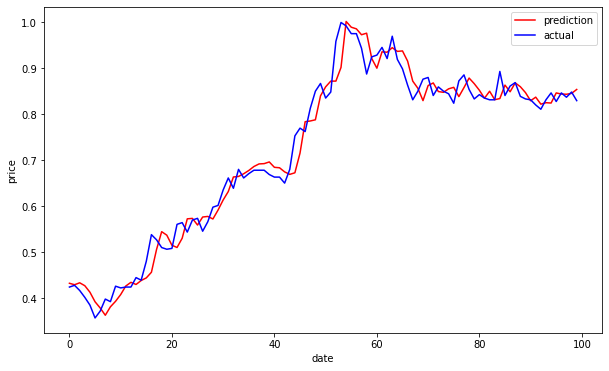

In [164]:
plt.figure(figsize=(10,6))
plt.plot(y_pred, 'r')
plt.plot(y_actual,'b')
plt.legend(['prediction','actual'])
plt.xlabel('date')
plt.ylabel('price')
plt.savefig('./samsungGRU.png')

In [ ]:
# LSTM 16 relu - LSTM 10 relu - Dense 1
model = create_model_LSTM(input_shape, 0.1, 16, 10)
y_pred = model.predict(X_test)
y_actual = y_test
plt.figure(figsize=(10,6))
plt.plot(y_pred, 'r')
plt.plot(y_actual,'b')
plt.legend(['prediction','actual'])
plt.xlabel('date')
plt.ylabel('price')
plt.savefig('./samsungGRU.png')

earlystopping = EarlyStopping(monitor = 'val_loss', patience=10)
checkpoint=ModelCheckpoint('best_stock_model_LSTM.h5',
                           save_weights_only=True,
                           save_best_only=True,
                           monitor='val_loss',
                           verbose=1)
history = model.fit(new_X_data, new_y_data, 
                    epochs = 1000,
                    batch_size=16,
                    validation_data=(X_val, y_val),
                    callbacks = [checkpoint, earlystopping])

Text(0, 0.5, 'price')

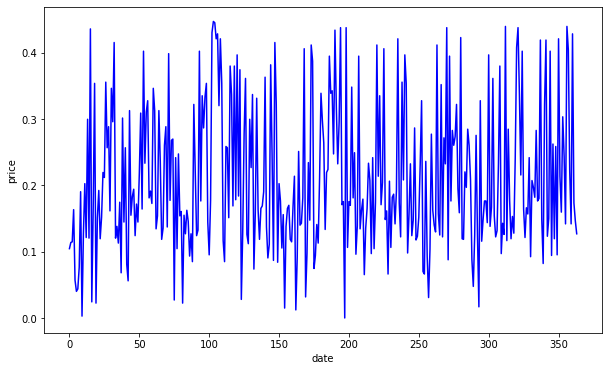

In [134]:
y_pred = model.predict(X_train)
y_actual = y_train
plt.figure(figsize=(10,6))
#plt.plot(y_pred, 'r')
plt.plot(y_actual,'b')
# plt.legend(['prediction','actual'])
plt.xlabel('date')
plt.ylabel('price')
# 퓨리에변환 해볼까

In [122]:
X_train.shape

(456, 30, 4)

In [123]:
y_train.shape

(456, 1)

In [124]:
y_pred.shape

(456, 1)

In [150]:
    #모델만들기.
    #16개의 신경망을 가진 LSTM. (None,20,4)의 인풋을 가지며, 활성화함수는 relu를쓰고, 역전파를 안한다.
model2 = Sequential()
model2.add(LSTM(16,
            input_shape =input_shape,
            activation='relu',
            return_sequences =False))

    #덴스 1층
model2.add(Dense(1))

    # 모니터링(무엇을 기준으로 patience를 볼 것인가.????)은 오차제곱평균을 기반으로하며 최적화는 아담으로 한다. 
model2.compile(loss='mean_squared_error', optimizer='adam')

In [151]:
earlystopping = EarlyStopping(monitor = 'val_loss', patience=10)
checkpoint=ModelCheckpoint('best_stock_model2.h5',
                           save_weights_only=True,
                           save_best_only=True,
                           monitor='val_loss',
                           verbose=1)
history = model2.fit(new_X_data, new_y_data, 
                    epochs = 1000,
                    batch_size=16,
                    validation_data=(X_val, y_val),
                    callbacks = [checkpoint, earlystopping])

Epoch 1/1000
42/42 [==============================] - 2s 19ms/step - loss: 0.1239 - val_loss: 0.0103

Epoch 00001: val_loss improved from inf to 0.01035, saving model to best_stock_model2.h5
Epoch 2/1000
42/42 [==============================] - 1s 13ms/step - loss: 0.0083 - val_loss: 0.0019

Epoch 00002: val_loss improved from 0.01035 to 0.00194, saving model to best_stock_model2.h5
Epoch 3/1000
42/42 [==============================] - 1s 13ms/step - loss: 0.0027 - val_loss: 0.0012

Epoch 00003: val_loss improved from 0.00194 to 0.00125, saving model to best_stock_model2.h5
Epoch 4/1000
42/42 [==============================] - 1s 13ms/step - loss: 0.0023 - val_loss: 0.0010

Epoch 00004: val_loss improved from 0.00125 to 0.00105, saving model to best_stock_model2.h5
Epoch 5/1000
42/42 [==============================] - 1s 15ms/step - loss: 0.0017 - val_loss: 9.2929e-04

Epoch 00005: val_loss improved from 0.00105 to 0.00093, saving model to best_stock_model2.h5
Epoch 6/1000
42/42 [=====

Text(0, 0.5, 'price')

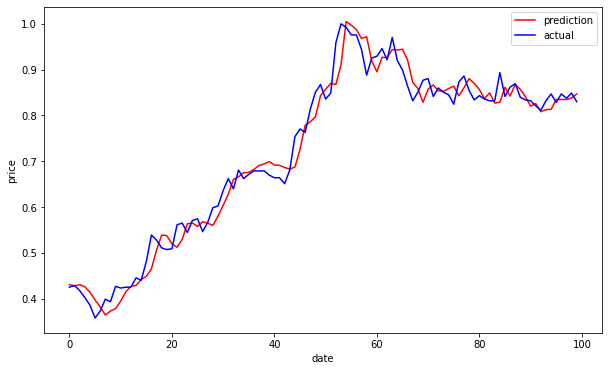

In [152]:
y_pred = model2.predict(X_test)
y_actual = y_test
plt.figure(figsize=(10,6))
plt.plot(y_pred, 'r')
plt.plot(y_actual,'b')
plt.legend(['prediction','actual'])
plt.xlabel('date')
plt.ylabel('price')
plt.savefig('./samsungLSTM1f_dense.png')

Text(0, 0.5, 'price')

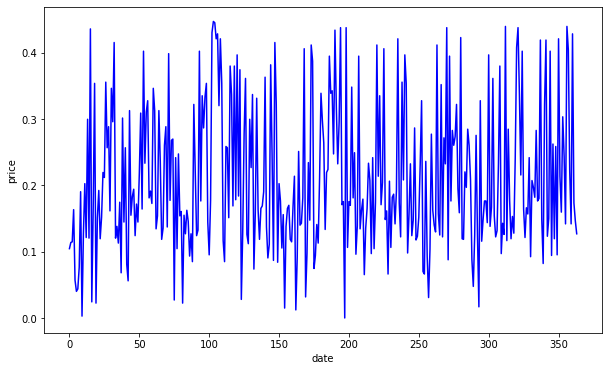

In [139]:
y_pred = model2.predict(X_train)
y_actual = y_train
plt.figure(figsize=(10,6))
#plt.plot(y_pred, 'r')
plt.plot(y_actual,'b')
# plt.legend(['prediction','actual'])
plt.xlabel('date')
plt.ylabel('price')